In [6]:
import datetime as dt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
import statsmodels.api as sm


# initialization
prob_switch = 0.2
stdev = 0.012623971978355785 # S&P500 전구간 stdev
R1, R2, R3 = 0.012, -0.009, 0.006 # return init value
INNER_STEPS = 10


def _gen_data(phi1, phi2, phi3, flag, stdev, drift, steps):
    # Initial values for lagged returns
    r1, r2, r3 = R1, R2, R3
    # Create data set based on AR(p)
    rets, flags = [], []
    for _ in range(0, steps):
        rt = drift + phi1*r1 + phi2*r2 + phi3*r3 + np.random.normal(loc=0, scale=stdev, size=1)
        flags.append(flag)
        rets.append(float(rt))
        r3, r2, r1 = r2, r1, rt
    return rets, flags


def _gen_dual_regime(phi, steps, inner_steps, prob_switch, stdev):
    rets, flags, is_regime_two = [], [], 0
    for _ in range(0, steps):
        is_regime_two =  np.random.uniform() < prob_switch

        if is_regime_two:
            rets_regime, flags_regime = _gen_data(phi1=-phi[0], phi2=-phi[1], phi3=-phi[2],
                                                  flag=1, steps=inner_steps,
                                                  stdev=stdev, drift=-0.0001)
        else:
            rets_regime, flags_regime = _gen_data(phi1=phi[0], phi2=phi[1], phi3=phi[2],
                                                  flag=0, steps=inner_steps,
                                                  stdev=stdev, drift=0.0001)
        rets.extend(rets_regime)
        flags.extend(flags_regime)
    return rets, flags


def dual_regime(total_steps, phi, prob_switch=prob_switch, stdev=stdev):
    # Params
    inner_steps = INNER_STEPS
    steps = int(total_steps / inner_steps)  # Set steps so that total steps is reached

    # Gen dual regime data
    rets, flags = _gen_dual_regime(phi = phi, steps=steps, inner_steps=inner_steps,
                                   prob_switch=prob_switch, stdev=stdev)

    # Convert to DF
    date_range = pd.date_range(end=dt.datetime.now(),
                               periods=steps * inner_steps,
                               freq='d', normalize=True)

    data = pd.DataFrame({'rets': np.array(rets).flatten(), 'flags': flags}, index=date_range)
    return data, get_SNR(data)


def prep_data(data, with_flags=True):
    # Set target variable
    data['target'] = data['rets'].apply(lambda x: 0 if x < 0 else 1).shift(-1)  # Binary classification
    data['target_rets'] = data['rets'].shift(-1)  # Add target rets for debugging
    data.dropna(inplace=True)

    # Auto-correlation trading rule: trade sign of previous day.
    data['pmodel'] = data['rets'].apply(lambda x: 1 if x > 0.0 else 0)

    # Strategy daily returns
    data['prets'] = (data['pmodel'] * data['target_rets']).shift(1)  # Lag by 1 to remove look ahead and align dates
    data.dropna(inplace=True)

    # Add lag rets 2 and 3 for Logistic regression
    data['rets2'] = data['rets'].shift(1)
    data['rets3'] = data['rets'].shift(2)

    # Add Regime indicator if with_flags is on
    if with_flags:
        data['regime'] = data['flags'].shift(5)

    model_data = data[data['pmodel'] == 1]
    return model_data.dropna(), data


def get_SNR(data):
    data = data['rets']
    data = pd.concat([data, data.shift(1), data.shift(2), data.shift(3)], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
    data = sm.tools.tools.add_constant(data)
    data.columns = ['Const', 'ret', 'ret(1)', 'ret(2)', 'ret(3)']
    model = sm.OLS(data['ret'], data.loc[:,['Const', 'ret(1)', 'ret(2)', 'ret(3)']])
    results = model.fit()
    return results.rsquared


def classification_stats(actual, predicted, prefix, get_specificity):
    # Create Report
    report = classification_report(actual, predicted, output_dict=True,
                                   labels=[0, 1], zero_division=0)
    # Extract (long only) metrics
    report['1'][prefix + '_accuracy'] = report['accuracy']
    report['1'][prefix + '_auc'] = roc_auc_score(actual, predicted)
    report['1'][prefix + '_macro_avg_f1'] = report['macro avg']['f1-score']
    report['1'][prefix + '_weighted_avg'] = report['weighted avg']['f1-score']

    # To DataFrame
    row = pd.DataFrame.from_dict(report['1'], orient='index').T
    row.columns = [prefix + '_precision', prefix + '_recall', prefix + '_f1_score',
                    prefix + '_support', prefix + '_accuracy', prefix + '_auc',
                    prefix + '_macro_avg_f1', prefix + '_weighted_avg_f1']

    # Add Specificity
    if get_specificity:
        row[prefix + '_specificity'] = report['0']['recall']
    else:
        row[prefix + '_specificity'] = 0

    return row

def de_prado_bet_size(prob_series, clip=True):
    # Can't compute for p = 1 or p = 0, leads to inf.
    p = prob_series.copy()
    p[p == 1] = 0.99999
    p[p == 0] = 0.00001
    # Getting max value from training set
    num_classes = 2
    dp_sizes = (p - 1 / num_classes) / ((p * (1 - p)) ** 0.5)
    dp_t_sizes = dp_sizes.apply(lambda s: norm.cdf(s))
    dp_bet_sizes = dp_t_sizes
    # no sigmoid function, only clipping?
    dp_bet_sizes[dp_bet_sizes < 0.5] = 0
    return dp_bet_sizes

def target_sigmoid(x):
    # Apply sigmoid position sizing
    f = lambda p: min(max(1 / (1 + np.exp(-x[0] * p - x[1])), 0), 1)
    f = np.vectorize(f)
    # Backtest + sharpe ratio
    rets = f(prob_train[prob_train > 0.5]) * target_train_p[prob_train > 0.5]
    # Solve for no positions taken
    mean, stdev = check_stats(rets)
    # Sharpe Ratio
    sharp_ratio = mean / stdev
    return -sharp_ratio

def target_iso_sigmoid(x):
    # Apply sigmoid position sizing
    f = lambda p: min(max(1 / (1 + np.exp(-x[0] * p - x[1])), 0), 1)
    f = np.vectorize(f)
    # Backtest + sharpe ratio
    rets = f(prob_sigmoid_train[prob_sigmoid_train > 0.5]) * target_train_p[prob_sigmoid_train > 0.5]
    # Solve for no positions taken
    mean, stdev = check_stats(rets)
    # Sharpe Ratio
    sharp_ratio = mean / stdev
    return -sharp_ratio

def check_stats(rets):
    if np.std(rets) == 0.0:
        stdev = 10000
    else:
        stdev = np.std(rets)

    if (np.mean(rets) <= 0.00001) and (np.mean(rets) >= -0.00001):
        mean = -10000
    else:
        mean = np.mean(rets)

    return mean, stdev


def target_linear(x):
    # Linear function
    f = lambda p: min(max(x[0] * p + x[1], 0), 1)
    f = np.vectorize(f)
    # Backtest
    rets = f(prob_train[prob_train > 0.5]) * target_train_p[prob_train > 0.5]
    # Solve for no positions taken
    mean, stdev = check_stats(rets)
    # Sharpe Ratio
    sr = mean / stdev
    return -sr


def target_linear_iso(x):
    # Linear function
    f = lambda p: min(max(x[0] * p + x[1], 0), 1)
    f = np.vectorize(f)
    # Backtest
    rets = f(prob_sigmoid_train[prob_sigmoid_train > 0.5]) * target_train_p[prob_sigmoid_train > 0.5]
    # Solve for no positions taken
    mean, stdev = check_stats(rets)
    # Sharp Ratio
    sr = mean / stdev
    return -sr


def kelly(p, win, loss):
    return (p / abs(loss)) - ((1 - p) / win)

def clip_kelly(b):
    return np.min([np.max([b, 0]), 1])

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import numpy as np


def plot_calibration_curve(y_true, y_prob, n_bins=10, ax=None, hist=True, normalize=False):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, normalize=normalize)
    if ax is None:
        ax = plt.gca()
    if hist:
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of positive samples")
    ax.set(aspect='equal')
    return curve

In [7]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as sp
import neptune
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve
from sklearn.preprocessing import StandardScaler
import quantstats as qs
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import brier_score_loss, f1_score, precision_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

hparams_ = {'steps': [200, 2000, 10000], 'SNR':[[-0.05, -0.05, 0.1], [0.4, -0.45, -0.4], [0.6, -0.45, 0.65]],
            'max_samples':[round(x,2) for x in np.linspace(0.6, 0.8, 2)], 'ccp_alpha':[round(x,4) for x in np.linspace(0., 0.001, 2)]}
hparams = (dict(zip(hparams_, i)) for i in product(*hparams_.values()))

dual_regime(phi = [0.6, -0.45, 0.65], total_steps = 200)

(                rets  flags
 2022-10-28  0.026917      0
 2022-10-29 -0.005906      0
 2022-10-30 -0.020984      0
 2022-10-31  0.022920      0
 2022-11-01  0.041439      0
 ...              ...    ...
 2023-05-11 -0.007567      0
 2023-05-12 -0.020035      0
 2023-05-13 -0.030825      0
 2023-05-14 -0.019508      0
 2023-05-15 -0.008908      0
 
 [200 rows x 2 columns],
 0.504691364831518)

In [8]:
data1, snr1 = dual_regime(phi = [0.6, -0.45, 0.65], total_steps = 2000)
data1

,rets,flags
2017-11-23,0.016261,0
2017-11-24,0.004152,0
2017-11-25,0.011438,0
2017-11-26,0.006240,0
2017-11-27,0.003068,0
...,...,...
2023-05-11,-0.010258,0
2023-05-12,-0.000718,0
2023-05-13,-0.003861,0
2023-05-14,-0.005627,0


In [9]:
data2, snr2 = dual_regime(phi = [-0.05, -0.05, 0.1], total_steps = 2000)
data2

,rets,flags
2017-11-23,0.025568,0
2017-11-24,0.002121,0
2017-11-25,0.004149,0
2017-11-26,-0.004501,0
2017-11-27,-0.009146,0
...,...,...
2023-05-11,-0.021714,0
2023-05-12,0.001846,0
2023-05-13,0.005536,0
2023-05-14,-0.007569,0


<AxesSubplot:>

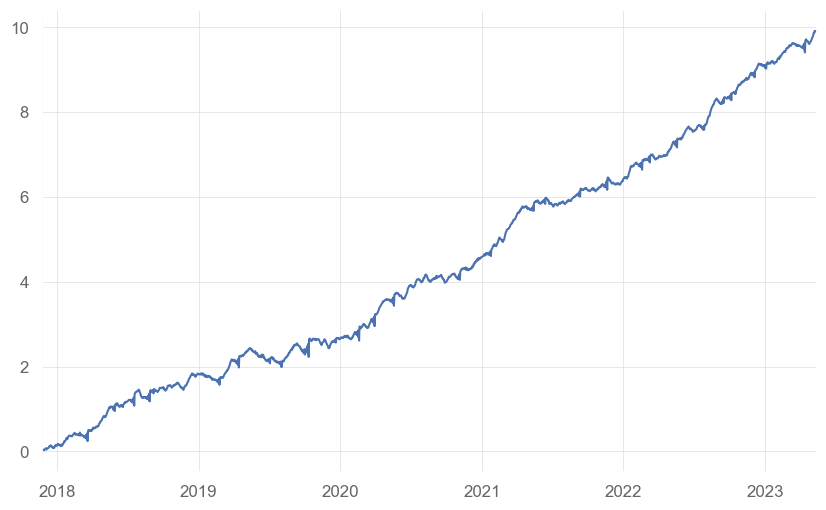

In [10]:
data1.rets.cumsum().plot() # high signal

<AxesSubplot:>

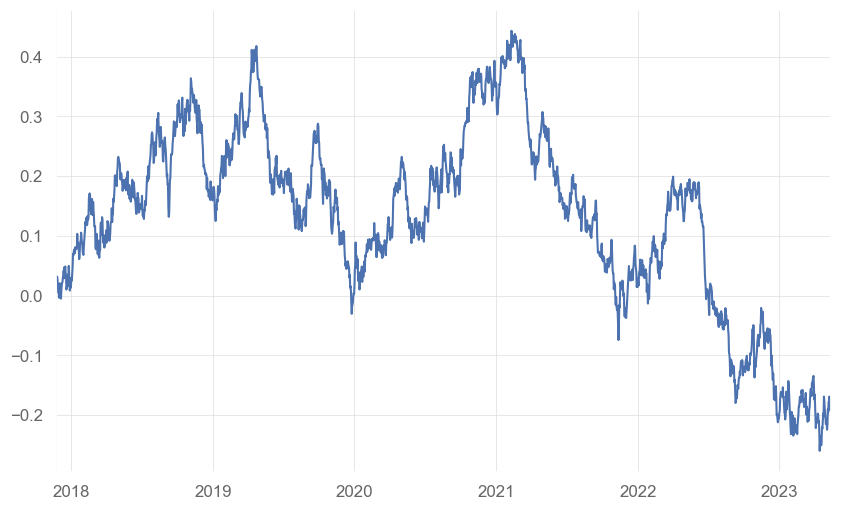

In [11]:
data2.rets.cumsum().plot() # low signal

In [12]:
data3, snr3 = dual_regime(phi = [0.4, -0.45, -0.4], total_steps = 2000)
data3

,rets,flags
2017-11-23,0.006991,0
2017-11-24,0.009605,0
2017-11-25,-0.005741,0
2017-11-26,-0.003720,0
2017-11-27,0.002708,0
...,...,...
2023-05-11,0.004663,0
2023-05-12,0.035644,0
2023-05-13,0.027429,0
2023-05-14,-0.016655,0


<AxesSubplot:>

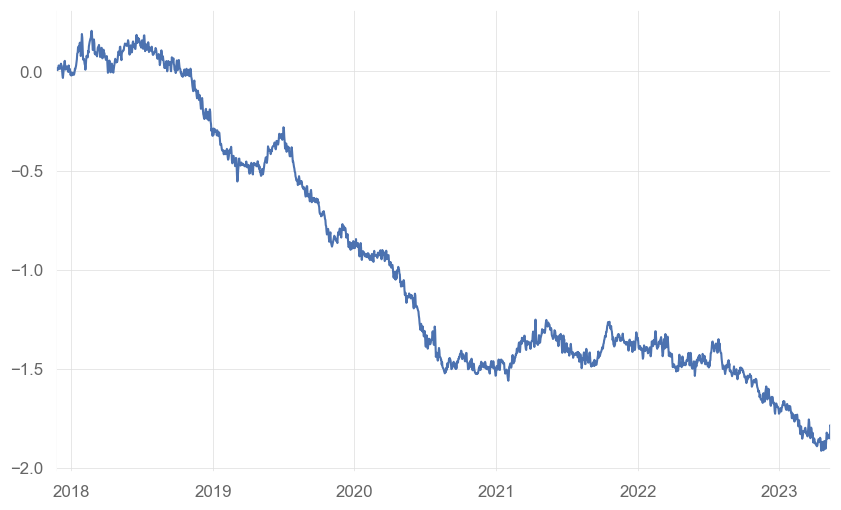

In [13]:
data3.rets.cumsum().plot()

In [14]:
model_data1, data1 = prep_data(data=data1, with_flags=True)

In [15]:
model_data1

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime
2017-11-30,0.015658,0,1.0,0.004361,1,0.000000,-0.010525,0.000867,0.0
2017-12-01,0.004361,0,1.0,0.008968,1,0.004361,0.015658,-0.010525,0.0
2017-12-02,0.008968,0,1.0,0.017878,1,0.008968,0.004361,0.015658,0.0
2017-12-03,0.017878,0,0.0,-0.018583,1,0.017878,0.008968,0.004361,0.0
2017-12-06,0.016854,0,1.0,0.007134,1,0.000000,-0.012886,-0.018583,0.0
...,...,...,...,...,...,...,...,...,...
2023-05-06,0.039378,0,1.0,0.024054,1,0.039378,0.033301,0.019638,0.0
2023-05-07,0.024054,0,1.0,0.001173,1,0.024054,0.039378,0.033301,0.0
2023-05-08,0.001173,0,1.0,0.032904,1,0.001173,0.024054,0.039378,0.0
2023-05-09,0.032904,0,1.0,0.011017,1,0.032904,0.001173,0.024054,0.0


In [16]:
data1

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime
2017-11-24,0.004152,0,1.0,0.011438,1,0.004152,NaN,NaN,NaN
2017-11-25,0.011438,0,1.0,0.006240,1,0.011438,0.004152,NaN,NaN
2017-11-26,0.006240,0,1.0,0.003068,1,0.006240,0.011438,0.004152,NaN
2017-11-27,0.003068,0,1.0,0.000867,1,0.003068,0.006240,0.011438,NaN
2017-11-28,0.000867,0,0.0,-0.010525,1,0.000867,0.003068,0.006240,NaN
...,...,...,...,...,...,...,...,...,...
2023-05-10,0.011017,0,0.0,-0.010258,1,0.011017,0.032904,0.001173,0.0
2023-05-11,-0.010258,0,0.0,-0.000718,0,-0.010258,0.011017,0.032904,0.0
2023-05-12,-0.000718,0,0.0,-0.003861,0,-0.000000,-0.010258,0.011017,0.0
2023-05-13,-0.003861,0,0.0,-0.005627,0,-0.000000,-0.000718,-0.010258,0.0


<AxesSubplot:>

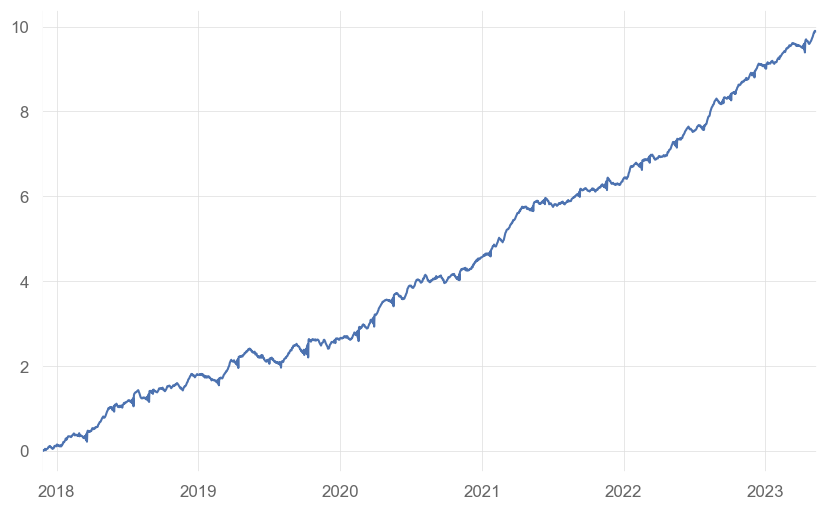

In [17]:
data1.target_rets.cumsum().plot()

In [18]:
model_data1

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime
2017-11-30,0.015658,0,1.0,0.004361,1,0.000000,-0.010525,0.000867,0.0
2017-12-01,0.004361,0,1.0,0.008968,1,0.004361,0.015658,-0.010525,0.0
2017-12-02,0.008968,0,1.0,0.017878,1,0.008968,0.004361,0.015658,0.0
2017-12-03,0.017878,0,0.0,-0.018583,1,0.017878,0.008968,0.004361,0.0
2017-12-06,0.016854,0,1.0,0.007134,1,0.000000,-0.012886,-0.018583,0.0
...,...,...,...,...,...,...,...,...,...
2023-05-06,0.039378,0,1.0,0.024054,1,0.039378,0.033301,0.019638,0.0
2023-05-07,0.024054,0,1.0,0.001173,1,0.024054,0.039378,0.033301,0.0
2023-05-08,0.001173,0,1.0,0.032904,1,0.001173,0.024054,0.039378,0.0
2023-05-09,0.032904,0,1.0,0.011017,1,0.032904,0.001173,0.024054,0.0


In [19]:
scaler = StandardScaler()
train, test = train_test_split(model_data1, test_size=0.3, shuffle=False)
X_train_regime = train[['rets', 'rets2', 'rets3', 'regime']]; y_train = train['target']
X_test_regime = test[['rets', 'rets2', 'rets3', 'regime']]; y_test = test['target']

In [20]:
X_train_regime_scaled = scaler.fit_transform(X_train_regime[['rets', 'rets2', 'rets3']])
regime = X_train_regime['regime'].values.reshape((-1, 1))
X_train_regime_scaled = np.append(X_train_regime_scaled, regime, axis=1)

In [21]:
X_test_regime_scaled = scaler.transform(X_test_regime[['rets', 'rets2', 'rets3']])
regime = X_test_regime['regime'].values.reshape((-1, 1))
X_test_regime_scaled = np.append(X_test_regime_scaled, regime, axis=1)

In [22]:
trained_model = RandomForestClassifier(n_estimators = 1000, ccp_alpha = 0.001, max_samples = 80)
fit = trained_model.fit(X_train_regime_scaled, y_train)

In [23]:
untrained_model = RandomForestClassifier(n_estimators = 1000, ccp_alpha = 0.001, max_samples = 80)

              precision    recall  f1-score   support

    no trade       0.64      0.56      0.60       125
       trade       0.77      0.83      0.80       227

    accuracy                           0.73       352
   macro avg       0.71      0.69      0.70       352
weighted avg       0.73      0.73      0.73       352



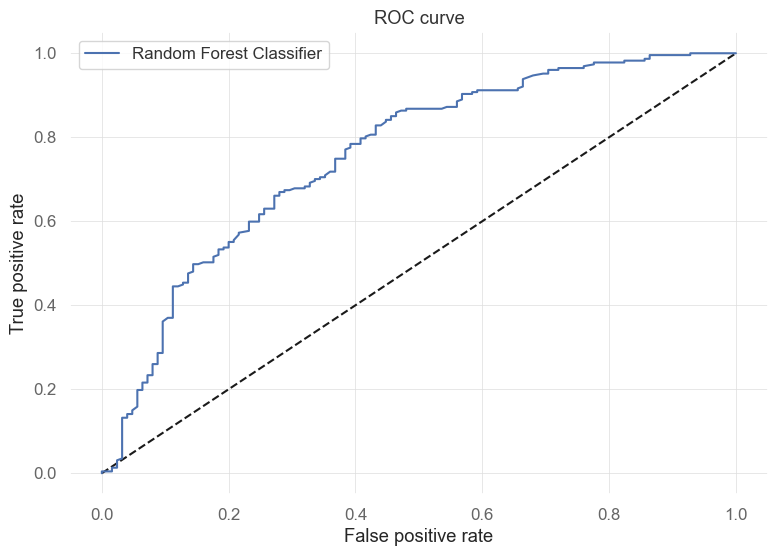

In [24]:
from sklearn import metrics
y_pred_rf = fit.predict_proba(X_test_regime_scaled)[:, 1]
y_pred = fit.predict(X_test_regime_scaled)
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_pred_rf)
print(metrics.classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [25]:
model_data2, data2 = prep_data(data=data2, with_flags=True)

In [26]:
model_data2

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime
2017-11-29,0.000111,0,0.0,-0.009241,1,0.000000,-0.012656,-0.009146,0.0
2017-12-01,0.000357,0,1.0,0.023833,1,0.000000,-0.009241,0.000111,0.0
2017-12-02,0.023833,0,0.0,-0.004481,1,0.023833,0.000357,-0.009241,0.0
2017-12-06,0.014633,0,1.0,0.008201,1,0.000000,-0.004175,-0.017048,0.0
2017-12-07,0.008201,0,1.0,0.003881,1,0.008201,0.014633,-0.004175,0.0
...,...,...,...,...,...,...,...,...,...
2023-05-08,0.017876,0,1.0,0.000170,1,0.000000,-0.005216,0.025530,0.0
2023-05-09,0.000170,0,1.0,0.008495,1,0.000170,0.017876,-0.005216,0.0
2023-05-10,0.008495,0,0.0,-0.021714,1,0.008495,0.000170,0.017876,0.0
2023-05-12,0.001846,0,1.0,0.005536,1,0.000000,-0.021714,0.008495,0.0


In [27]:
scaler = StandardScaler()
train, test = train_test_split(model_data2, test_size=0.3, shuffle=False)
X_train_regime = train[['rets', 'rets2', 'rets3', 'regime']]; y_train = train['target']
X_test_regime = test[['rets', 'rets2', 'rets3', 'regime']]; y_test = test['target']

In [28]:
X_train_regime_scaled = scaler.fit_transform(X_train_regime[['rets', 'rets2', 'rets3']])
regime = X_train_regime['regime'].values.reshape((-1, 1))
X_train_regime_scaled = np.append(X_train_regime_scaled, regime, axis=1)

In [29]:
X_test_regime_scaled = scaler.transform(X_test_regime[['rets', 'rets2', 'rets3']])
regime = X_test_regime['regime'].values.reshape((-1, 1))
X_test_regime_scaled = np.append(X_test_regime_scaled, regime, axis=1)

In [30]:
trained_model = RandomForestClassifier(n_estimators = 1000, ccp_alpha = 0.001, max_samples = 80)
fit = trained_model.fit(X_train_regime_scaled, y_train)

In [31]:
untrained_model = RandomForestClassifier(n_estimators = 1000, ccp_alpha = 0.001, max_samples = 80)

              precision    recall  f1-score   support

    no trade       0.55      0.63      0.59       160
       trade       0.48      0.40      0.44       138

    accuracy                           0.52       298
   macro avg       0.52      0.51      0.51       298
weighted avg       0.52      0.52      0.52       298



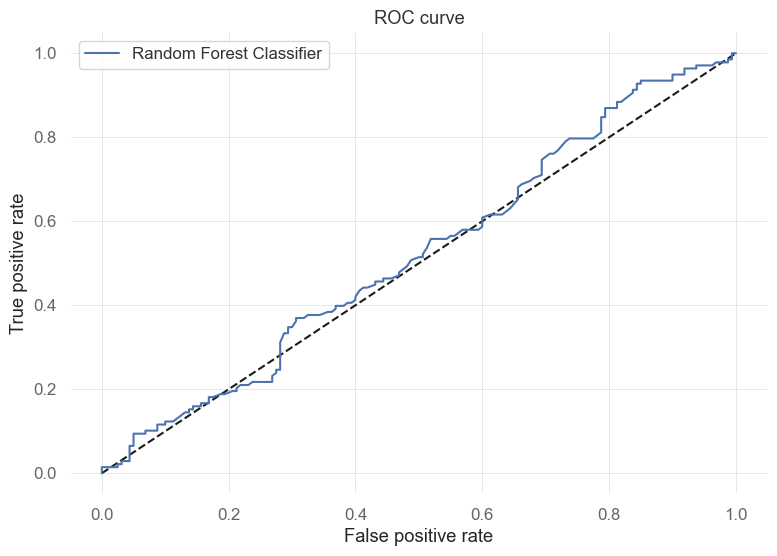

In [32]:
from sklearn import metrics
y_pred_rf = fit.predict_proba(X_test_regime_scaled)[:, 1]
y_pred = fit.predict(X_test_regime_scaled)
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_pred_rf)
print(metrics.classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [33]:
model_data3, data3 = prep_data(data=data3, with_flags=True)

In [34]:
model_data2

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime
2017-11-29,0.000111,0,0.0,-0.009241,1,0.000000,-0.012656,-0.009146,0.0
2017-12-01,0.000357,0,1.0,0.023833,1,0.000000,-0.009241,0.000111,0.0
2017-12-02,0.023833,0,0.0,-0.004481,1,0.023833,0.000357,-0.009241,0.0
2017-12-06,0.014633,0,1.0,0.008201,1,0.000000,-0.004175,-0.017048,0.0
2017-12-07,0.008201,0,1.0,0.003881,1,0.008201,0.014633,-0.004175,0.0
...,...,...,...,...,...,...,...,...,...
2023-05-08,0.017876,0,1.0,0.000170,1,0.000000,-0.005216,0.025530,0.0
2023-05-09,0.000170,0,1.0,0.008495,1,0.000170,0.017876,-0.005216,0.0
2023-05-10,0.008495,0,0.0,-0.021714,1,0.008495,0.000170,0.017876,0.0
2023-05-12,0.001846,0,1.0,0.005536,1,0.000000,-0.021714,0.008495,0.0


In [35]:
scaler = StandardScaler()
train, test = train_test_split(model_data3, test_size=0.3, shuffle=False)
X_train_regime = train[['rets', 'rets2', 'rets3', 'regime']]; y_train = train['target']
X_test_regime = test[['rets', 'rets2', 'rets3', 'regime']]; y_test = test['target']

In [36]:
X_train_regime_scaled = scaler.fit_transform(X_train_regime[['rets', 'rets2', 'rets3']])
regime = X_train_regime['regime'].values.reshape((-1, 1))
X_train_regime_scaled = np.append(X_train_regime_scaled, regime, axis=1)

In [37]:
X_test_regime_scaled = scaler.transform(X_test_regime[['rets', 'rets2', 'rets3']])
regime = X_test_regime['regime'].values.reshape((-1, 1))
X_test_regime_scaled = np.append(X_test_regime_scaled, regime, axis=1)

In [38]:
trained_model = RandomForestClassifier(n_estimators = 1000, ccp_alpha = 0.001, max_samples = 80)
fit = trained_model.fit(X_train_regime_scaled, y_train)

In [39]:
untrained_model = RandomForestClassifier(n_estimators = 1000, ccp_alpha = 0.001, max_samples = 80)

              precision    recall  f1-score   support

    no trade       0.64      0.61      0.62       133
       trade       0.68      0.70      0.69       155

    accuracy                           0.66       288
   macro avg       0.66      0.66      0.66       288
weighted avg       0.66      0.66      0.66       288



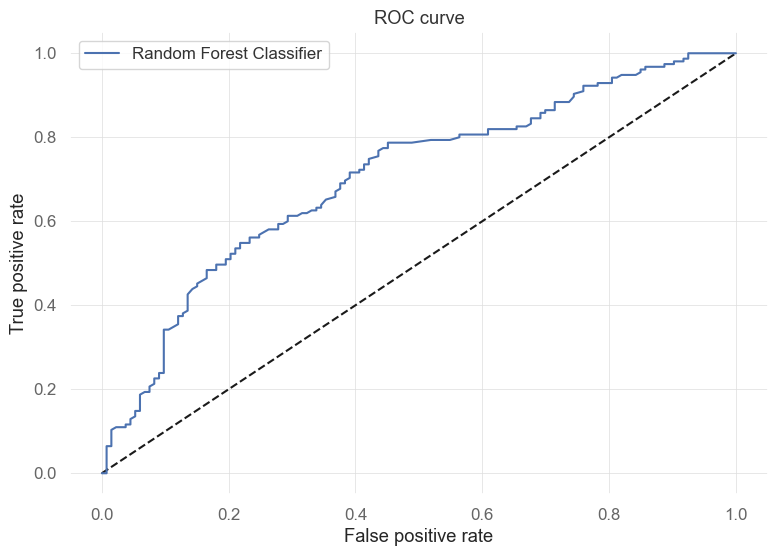

In [40]:
from sklearn import metrics
y_pred_rf = fit.predict_proba(X_test_regime_scaled)[:, 1]
y_pred = fit.predict(X_test_regime_scaled)
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_pred_rf)
print(metrics.classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [41]:
def plotMetrics(X_test, y_test) :
    y_pred_rf = fit.predict_proba(X_test)[:, 1]
    y_pred = fit.predict(X_test)
    fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_pred_rf)
    print(metrics.classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

    plt.figure(figsize = (9,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label = 'Random Forest Classifier')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

              precision    recall  f1-score   support

    no trade       0.64      0.61      0.62       133
       trade       0.68      0.70      0.69       155

    accuracy                           0.66       288
   macro avg       0.66      0.66      0.66       288
weighted avg       0.66      0.66      0.66       288



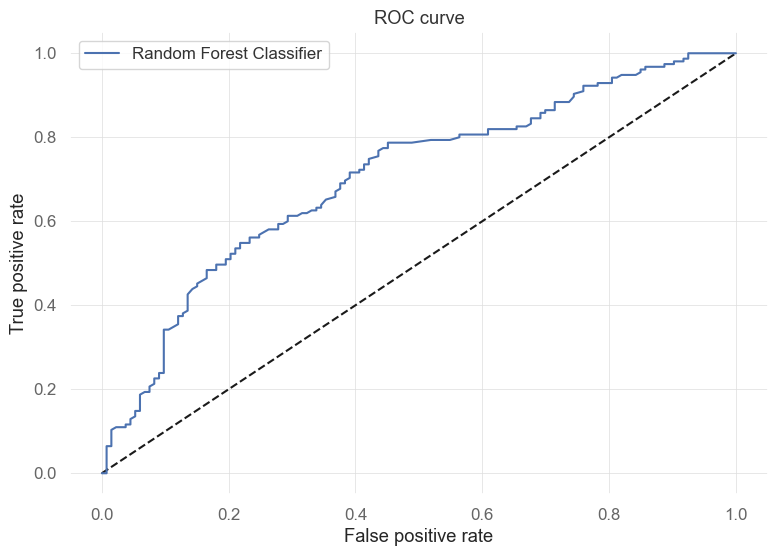

In [42]:
plotMetrics(X_test_regime_scaled, y_test)

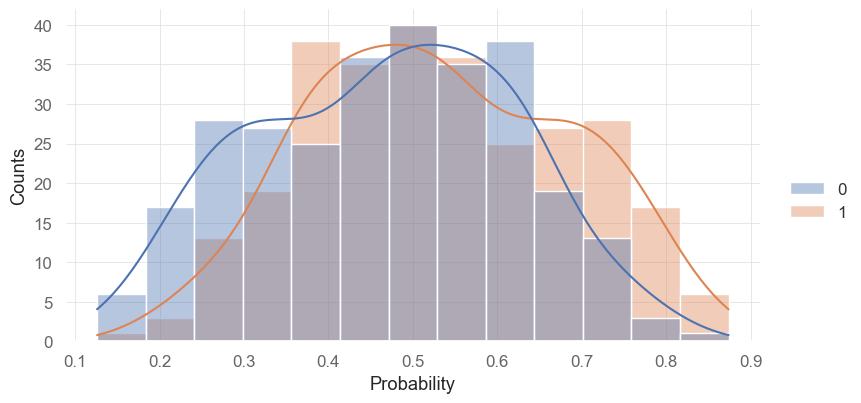

In [43]:
import seaborn as sns
ax = sns.displot(fit.predict_proba(X_test_regime_scaled), height = 4, aspect = 2, alpha = 0.4, kde = True)
ax.set_xlabels('Probability')
ax.set_ylabels('Counts')

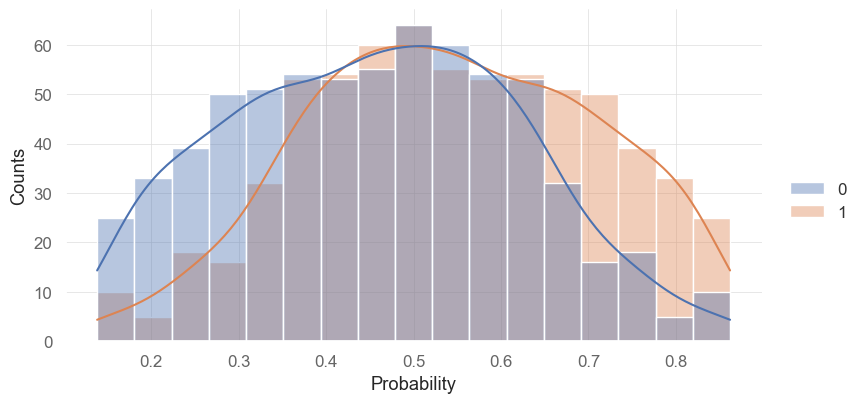

In [44]:
ax = sns.displot(fit.predict_proba(X_train_regime_scaled), height = 4, aspect = 2, alpha = 0.4, kde = True)
ax.set_xlabels('Probability')
ax.set_ylabels('Counts')

In [49]:
def plotMetrics(X_test, y_test, fit, ax = None, hist = True) :
    y_pred_rf = fit.predict_proba(X_test)[:, 1]
    y_pred = fit.predict(X_test)
    fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_pred_rf)
    print(metrics.classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

    if ax is None :
        ax = plt.gca()

    if hist :
        ax.displot(fit.predict_proba(X_test), height=4, aspect=2, alpha=0.4, kde=True)

    ax.set_xlabels('Probability')
    ax.set_ylabels('Counts')

    return ax

              precision    recall  f1-score   support

    no trade       0.64      0.61      0.62       133
       trade       0.68      0.70      0.69       155

    accuracy                           0.66       288
   macro avg       0.66      0.66      0.66       288
weighted avg       0.66      0.66      0.66       288



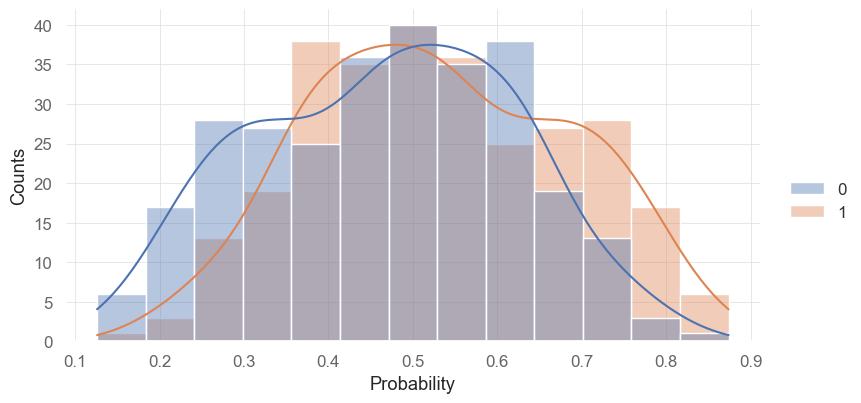

In [51]:
ax = plotMetrics(X_test_regime_scaled, y_test, fit)

<AxesSubplot:ylabel='Density'>

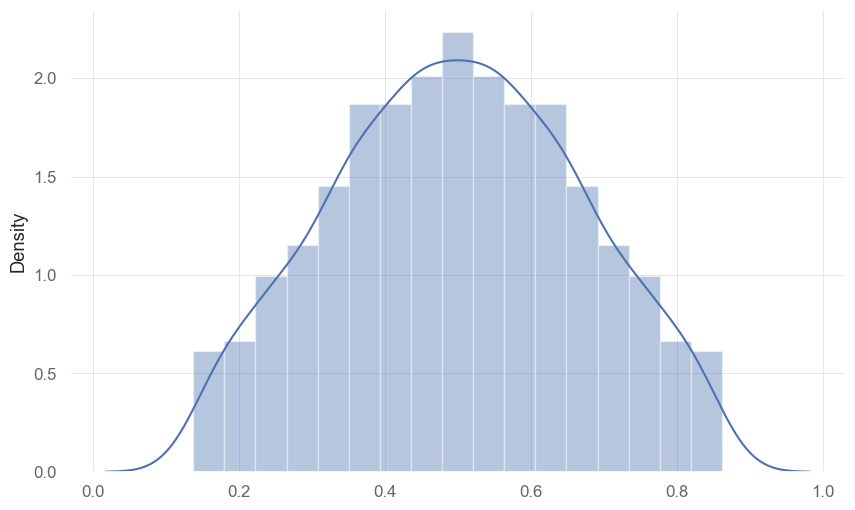

In [83]:
sns.distplot([pd.DataFrame(fit.predict_proba(X_train_regime_scaled))[[0]], pd.DataFrame(fit.predict_proba(X_train_regime_scaled))[[1]]], kde=True, label = "0")

In [69]:
fit.predict_proba(X_train_regime_scaled)

array([[0.497, 0.503],
       [0.277, 0.723],
       [0.331, 0.669],
       ...,
       [0.446, 0.554],
       [0.403, 0.597],
       [0.5  , 0.5  ]])

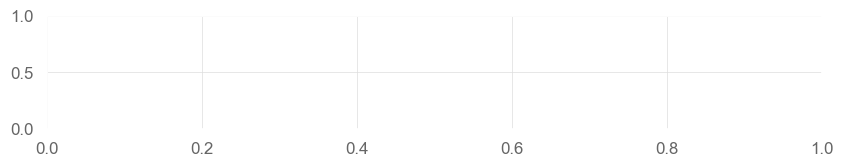

In [87]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(3, 1, 1)